# 04.1a: Sky Map - Directional Structure in γ' Space

**Goal:** Visualize the directional distribution of tokens in γ'-space (centered at cloud centroid).

We'll:
1. Load γ' (centered embedding matrix)
2. Compute PCA to get principal component axes
3. Choose three orthogonal PC axes to define our coordinate system
4. Convert all tokens to spherical coordinates (longitude φ, latitude θ)
5. Apply CDF-flattening to spread narrow latitude distribution for visibility
6. Create sky map: longitude vs flattened-latitude, colored by jet membership

**Key insight:** Tokens lie on approximate spherical shell in γ'-space, so latitudes cluster near equator (±3°). CDF transform spreads them to full [-90°, +90°] range while preserving rank order and relative positions.

## Parameters

In [19]:
TENSOR_DIR = "../data/tensors"

# Coordinate system: which PC axes define our spherical coordinates?
# NORTH_PC: defines the north pole (latitude +90°)
# MERIDIAN_PC: defines the prime meridian (longitude 0°)
# EQUINOX_PC: completes the right-handed coordinate system
NORTH_PC = 1
MERIDIAN_PC = 2
EQUINOX_PC = 3

# Viewing direction: rotate plot so this longitude is centered
# Range: -180 to 180 degrees
# Example: HEADING = -120 puts -120° longitude in the middle of the plot
HEADING = 0

# Projection type: 'rectangular' or 'mollweide'
PROJECTION = 'rectangular'

# Zoom: set specific ranges for rectangular projection
# Set to None to show full sky (-180 to 180 lon, -90 to 90 lat)
LON_MIN = None
LON_MAX = None
LAT_MIN = None
LAT_MAX = None

# Mask out degenerate tokens?
MASK_DEGENERATE = True  # Set to True to hide the 814-token singularity

# Visualization
POINT_SIZE = 1
POINT_ALPHA = 1
FIGURE_DPI = 100

## Imports

In [20]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [21]:
# Load centered gamma prime
gamma_prime_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_prime = load_file(gamma_prime_path)['gamma_centered']

N, d = gamma_prime.shape

print(f"Loaded γ' (centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Load jet mask
jet_mask_path = Path(TENSOR_DIR) / "jet_mask.safetensors"
jet_mask = load_file(jet_mask_path)['jet_mask']

n_jet = jet_mask.sum().item()
n_bulk = (~jet_mask).sum().item()

print(f"Loaded jet mask:")
print(f"  Jet tokens: {n_jet:,} ({n_jet/N*100:.2f}%)")
print(f"  Bulk tokens: {n_bulk:,} ({n_bulk/N*100:.2f}%)")
print()

# Create degenerate token mask
if MASK_DEGENERATE:
    print("Creating degenerate token mask...")
    # Reference token for degenerate cluster
    ref_id = 149415
    reference = gamma_prime[ref_id]
    
    # Find all exactly equal tokens
    degenerate_mask = torch.all(gamma_prime == reference, dim=1)
    n_degenerate = degenerate_mask.sum().item()
    
    print(f"  Found {n_degenerate:,} degenerate tokens ({n_degenerate/N*100:.4f}%)")
    print(f"  These will be excluded from the plot.")
else:
    degenerate_mask = torch.zeros(N, dtype=torch.bool)
    n_degenerate = 0
    print("Degenerate masking disabled.")

Loaded γ' (centered):
  Tokens: 151,936
  Dimensions: 2,560

Loaded jet mask:
  Jet tokens: 3,055 (2.01%)
  Bulk tokens: 148,881 (97.99%)

Creating degenerate token mask...
  Found 814 degenerate tokens (0.5358%)
  These will be excluded from the plot.


## Step 2: Compute PCA

Compute eigenvectors of Cov(γ') to get principal component basis vectors.

In [22]:
print("Computing covariance matrix...")
# Cov(γ') = (γ')ᵀ γ' / (N-1)
Cov = (gamma_prime.T @ gamma_prime) / (N - 1)

print(f"Covariance matrix shape: {Cov.shape}")
print(f"Computing eigendecomposition...\n")

# Eigendecomposition
eigenvalues, eigenvectors = torch.linalg.eigh(Cov)

# Sort descending (highest variance first)
eigenvalues = eigenvalues.flip(0)
eigenvectors = eigenvectors.flip(1)

print(f"Top 10 eigenvalues:")
for i in range(10):
    variance_explained = eigenvalues[i] / eigenvalues.sum()
    print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}%)")

print(f"\nPCA computed successfully.")

Computing covariance matrix...
Covariance matrix shape: torch.Size([2560, 2560])
Computing eigendecomposition...

Top 10 eigenvalues:
  PC1: λ = 1.048719e-02 (0.94%)
  PC2: λ = 3.177739e-03 (0.28%)
  PC3: λ = 2.791374e-03 (0.25%)
  PC4: λ = 2.616169e-03 (0.23%)
  PC5: λ = 1.973001e-03 (0.18%)
  PC6: λ = 1.805293e-03 (0.16%)
  PC7: λ = 1.609086e-03 (0.14%)
  PC8: λ = 1.549411e-03 (0.14%)
  PC9: λ = 1.468294e-03 (0.13%)
  PC10: λ = 1.389096e-03 (0.12%)

PCA computed successfully.


## Step 3: Define Coordinate System

Extract the three PC axes that define our spherical coordinate system.

In [23]:
# Extract basis vectors (PCs are 0-indexed, so subtract 1)
north_vector = eigenvectors[:, NORTH_PC - 1]      # Defines north pole
meridian_vector = eigenvectors[:, MERIDIAN_PC - 1]  # Defines prime meridian
equinox_vector = eigenvectors[:, EQUINOX_PC - 1]   # Completes right-handed system

print(f"Coordinate system:")
print(f"  North pole: PC{NORTH_PC}")
print(f"  Prime meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")
print()

# Verify orthonormality
dot_nm = (north_vector @ meridian_vector).item()
dot_ne = (north_vector @ equinox_vector).item()
dot_me = (meridian_vector @ equinox_vector).item()

print(f"Orthogonality check (should all be ~0):")
print(f"  North · Meridian: {dot_nm:.6f}")
print(f"  North · Equinox: {dot_ne:.6f}")
print(f"  Meridian · Equinox: {dot_me:.6f}")
print()

norm_n = north_vector.norm().item()
norm_m = meridian_vector.norm().item()
norm_e = equinox_vector.norm().item()

print(f"Normalization check (should all be ~1):")
print(f"  ||North||: {norm_n:.6f}")
print(f"  ||Meridian||: {norm_m:.6f}")
print(f"  ||Equinox||: {norm_e:.6f}")

Coordinate system:
  North pole: PC1
  Prime meridian: PC2
  Equinox: PC3

Orthogonality check (should all be ~0):
  North · Meridian: 0.000000
  North · Equinox: 0.000000
  Meridian · Equinox: 0.000000

Normalization check (should all be ~1):
  ||North||: 1.000000
  ||Meridian||: 0.999999
  ||Equinox||: 1.000000


## Step 4: Convert to Spherical Coordinates

Project each token onto the three basis vectors to get Cartesian coordinates, then convert to spherical.

**Convention:**
- **Latitude θ**: angle from equatorial plane, range [-90°, +90°]
  - θ = 0° at equator
  - θ = +90° at north pole
  - θ = -90° at south pole
- **Longitude φ**: angle in equatorial plane, range [-180°, +180°]
  - φ = 0° along prime meridian (MERIDIAN_PC direction)
  - φ = +90° along equinox direction
  - φ = ±180° opposite prime meridian

In [24]:
print(f"Converting {N:,} tokens to spherical coordinates...\n")

# Project onto basis vectors to get Cartesian coordinates in our frame
x = gamma_prime @ meridian_vector  # Prime meridian direction
y = gamma_prime @ equinox_vector   # Equinox direction
z = gamma_prime @ north_vector     # North pole direction

# Compute radius (distance from origin)
r = torch.sqrt(x**2 + y**2 + z**2)

# Latitude: arcsin(z/r)
# Range: -π/2 to π/2 radians
theta_rad = torch.asin(torch.clamp(z / r, -1, 1))
theta_deg = torch.rad2deg(theta_rad)

# Longitude: atan2(y, x)
# Range: -π to π radians
phi_rad = torch.atan2(y, x)
phi_deg = torch.rad2deg(phi_rad)

print(f"Spherical coordinates computed.")
print()
print(f"Radius statistics:")
print(f"  Mean: {r.mean().item():.6f} gamma units")
print(f"  Std: {r.std().item():.6f} gamma units")
print(f"  Min: {r.min().item():.6f} gamma units")
print(f"  Max: {r.max().item():.6f} gamma units")
print()
print(f"Latitude statistics (before CDF flattening):")
print(f"  Mean: {theta_deg.mean().item():.6f}°")
print(f"  Std: {theta_deg.std().item():.6f}°")
print(f"  Min: {theta_deg.min().item():.6f}°")
print(f"  Max: {theta_deg.max().item():.6f}°")
print()
print(f"Longitude statistics:")
print(f"  Mean: {phi_deg.mean().item():.6f}°")
print(f"  Std: {phi_deg.std().item():.6f}°")
print(f"  Min: {phi_deg.min().item():.6f}°")
print(f"  Max: {phi_deg.max().item():.6f}°")

Converting 151,936 tokens to spherical coordinates...

Spherical coordinates computed.

Radius statistics:
  Mean: 0.112279 gamma units
  Std: 0.062046 gamma units
  Min: 0.002472 gamma units
  Max: 1.095257 gamma units

Latitude statistics (before CDF flattening):
  Mean: 5.255265°
  Std: 49.628139°
  Min: -89.923386°
  Max: 89.680405°

Longitude statistics:
  Mean: 10.975709°
  Std: 100.304588°
  Min: -179.992325°
  Max: 179.998184°


## Step 5: Apply CDF Flattening to Latitude

Tokens cluster near the equator because they lie on an approximate spherical shell. We use the empirical CDF to spread the latitude distribution uniformly across [-90°, +90°] while preserving rank order.

In [25]:
print("Computing empirical CDF of latitude distribution...\n")

# Sort latitudes to compute empirical CDF
theta_sorted, sort_indices = torch.sort(theta_deg)

# Empirical CDF values: linearly spaced from 0 to 1
cdf_values = torch.linspace(0, 1, N)

# Map CDF values to uniform [-90°, +90°] range
# CDF = 0 → -90°, CDF = 1 → +90°
theta_flat_sorted = 90.0 * (2.0 * cdf_values - 1.0)

# Unsort to get back to original token order
theta_flat = torch.zeros_like(theta_deg)
theta_flat[sort_indices] = theta_flat_sorted

print(f"CDF flattening complete.")
print()
print(f"Flattened latitude statistics:")
print(f"  Mean: {theta_flat.mean().item():.6f}°")
print(f"  Std: {theta_flat.std().item():.6f}°")
print(f"  Min: {theta_flat.min().item():.6f}°")
print(f"  Max: {theta_flat.max().item():.6f}°")
print()
print(f"Latitude range before flattening: {theta_deg.max().item() - theta_deg.min().item():.2f}°")
print(f"Latitude range after flattening: {theta_flat.max().item() - theta_flat.min().item():.2f}°")

Computing empirical CDF of latitude distribution...

CDF flattening complete.

Flattened latitude statistics:
  Mean: -0.000001°
  Std: 51.962036°
  Min: -90.000000°
  Max: 90.000000°

Latitude range before flattening: 179.60°
Latitude range after flattening: 180.00°


## Step 6: Apply Heading Rotation

Rotate the longitude axis so the specified HEADING appears in the center of the plot.

In [26]:
# Shift longitude by HEADING degrees
phi_rotated = phi_deg - HEADING

# Wrap to [-180°, +180°] range
phi_rotated = torch.where(phi_rotated > 180, phi_rotated - 360, phi_rotated)
phi_rotated = torch.where(phi_rotated < -180, phi_rotated + 360, phi_rotated)

print(f"Applied heading rotation: {HEADING}°")
print(f"Longitude {HEADING}° now appears at center of plot (longitude 0°)")

Applied heading rotation: 0°
Longitude 0° now appears at center of plot (longitude 0°)


## Step 7: Create Sky Map

Plot longitude (x-axis) vs flattened latitude (y-axis), colored by jet membership.

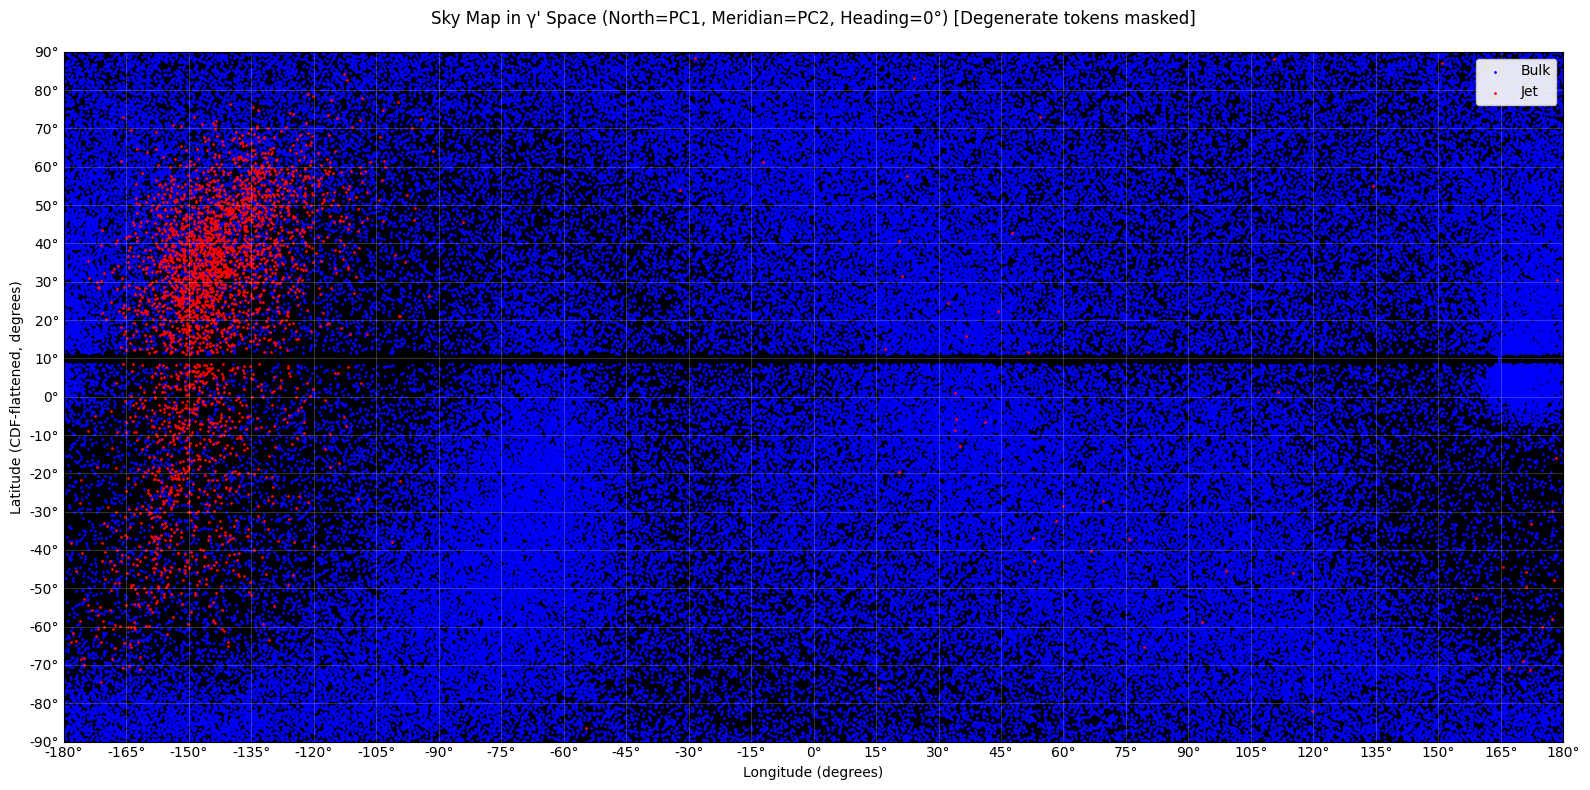


Sky map complete (rectangular projection).
  Total points plotted: 151,122 (of 151,936 total)
  Masked out: 814 degenerate tokens
  Jet points: 3,055 (red)
  Bulk points: 148,067 (blue)


In [27]:
# Create combined mask: exclude degenerate tokens from plotting
plot_mask = ~degenerate_mask

# Convert to numpy for plotting
phi_rotated_np = phi_rotated.cpu().numpy()
theta_flat_np = theta_flat.cpu().numpy()
jet_mask_np = jet_mask.cpu().numpy()
plot_mask_np = plot_mask.cpu().numpy()

# Apply plot mask
phi_plot = phi_rotated_np[plot_mask_np]
theta_plot = theta_flat_np[plot_mask_np]
jet_plot = jet_mask_np[plot_mask_np]

# Convert to radians for Mollweide projection
phi_plot_rad = np.deg2rad(phi_plot)
theta_plot_rad = np.deg2rad(theta_plot)

n_plotted = len(phi_plot)
n_jet_plotted = jet_plot.sum()
n_bulk_plotted = (~jet_plot).sum()

# Create figure with appropriate projection
if PROJECTION == 'mollweide':
    fig = plt.figure(figsize=(16, 8), dpi=FIGURE_DPI)
    ax = fig.add_subplot(111, projection='mollweide')
    ax.set_facecolor('black')
    
    # Plot bulk first (so jet appears on top)
    ax.scatter(phi_plot_rad[~jet_plot], theta_plot_rad[~jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='blue', label='Bulk', rasterized=True)
    
    # Plot jet
    ax.scatter(phi_plot_rad[jet_plot], theta_plot_rad[jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='red', label='Jet', rasterized=True)
    
    # Grid lines: latitude every 10°, longitude every 15°
    ax.grid(True, alpha=0.2, color='white')
    
    # Remove tick marks and labels for Mollweide
    ax.tick_params(axis='both', which='both', length=0, colors='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
else:  # rectangular
    fig, ax = plt.subplots(figsize=(16, 8), dpi=FIGURE_DPI)
    ax.set_facecolor('black')
    
    # Plot bulk first (so jet appears on top)
    ax.scatter(phi_plot[~jet_plot], theta_plot[~jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='blue', label='Bulk', rasterized=True)
    
    # Plot jet
    ax.scatter(phi_plot[jet_plot], theta_plot[jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='red', label='Jet', rasterized=True)
    
    # Determine plot limits (use zoom if specified, otherwise full sky)
    lon_min = LON_MIN if LON_MIN is not None else -180
    lon_max = LON_MAX if LON_MAX is not None else 180
    lat_min = LAT_MIN if LAT_MIN is not None else -90
    lat_max = LAT_MAX if LAT_MAX is not None else 90
    
    # Set tick spacing: longitude every 15°, latitude every 10°
    # Adjust to reasonable spacing for zoomed views
    lon_range = lon_max - lon_min
    lat_range = lat_max - lat_min
    
    # Choose tick spacing based on range
    if lon_range <= 20:
        lon_tick_spacing = 1
    elif lon_range <= 60:
        lon_tick_spacing = 5
    else:
        lon_tick_spacing = 15
    
    if lat_range <= 20:
        lat_tick_spacing = 1
    elif lat_range <= 60:
        lat_tick_spacing = 5
    else:
        lat_tick_spacing = 10
    
    # Generate ticks within the visible range
    lon_ticks = np.arange(
        np.ceil(lon_min / lon_tick_spacing) * lon_tick_spacing,
        lon_max + lon_tick_spacing,
        lon_tick_spacing
    )
    lat_ticks = np.arange(
        np.ceil(lat_min / lat_tick_spacing) * lat_tick_spacing,
        lat_max + lat_tick_spacing,
        lat_tick_spacing
    )
    
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    
    # Format tick labels
    ax.set_xticklabels([f'{int(lon)}°' for lon in lon_ticks])
    ax.set_yticklabels([f'{int(lat)}°' for lat in lat_ticks])
    
    # Remove tick marks but keep labels
    ax.tick_params(axis='both', which='both', length=0, colors='black')
    
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.grid(True, alpha=0.2, color='white', which='major')

# Common formatting for both projections
ax.set_xlabel('Longitude (degrees)', color='black')
ax.set_ylabel('Latitude (CDF-flattened, degrees)', color='black')

# Update title to show zoom range and masking status
if PROJECTION == 'rectangular' and (LON_MIN is not None or LAT_MIN is not None):
    title = f'Sky Map in γ\' Space (North=PC{NORTH_PC}, Meridian=PC{MERIDIAN_PC}, Heading={HEADING}°)\n'
    title += f'Zoom: Lon [{lon_min}°, {lon_max}°], Lat [{lat_min}°, {lat_max}°]'
else:
    title = f'Sky Map in γ\' Space (North=PC{NORTH_PC}, Meridian=PC{MERIDIAN_PC}, Heading={HEADING}°)'

if MASK_DEGENERATE:
    title += f' [Degenerate tokens masked]'

ax.set_title(title, color='black', pad=20)
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Legend with opaque markers
legend = ax.legend(loc='upper right', framealpha=0.9)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nSky map complete ({PROJECTION} projection).")
if PROJECTION == 'rectangular' and (LON_MIN is not None or LAT_MIN is not None):
    print(f"  Zoom: Longitude [{lon_min}°, {lon_max}°], Latitude [{lat_min}°, {lat_max}°]")
print(f"  Total points plotted: {n_plotted:,} (of {N:,} total)")
if MASK_DEGENERATE:
    print(f"  Masked out: {n_degenerate:,} degenerate tokens")
print(f"  Jet points: {n_jet_plotted:,} (red)")
print(f"  Bulk points: {n_bulk_plotted:,} (blue)")

## Summary

We created a sky map showing the directional distribution of tokens in γ'-space.

**Method:**
- Computed PCA to find principal component axes
- Chose three orthogonal PC axes to define spherical coordinate system
- Converted all tokens to (longitude, latitude) coordinates
- Applied CDF-flattening to spread narrow latitude distribution
- Rotated view to place specified HEADING at center

**Interpretation:**
- Red points (jet) show syntactic token cluster
- Blue points (bulk) show semantic token population
- Spatial separation on map corresponds to angular separation in 2560D space
- CDF-flattened latitudes preserve rank order but spread for visibility